# **📦 Imports**
We start by importing all the essential Python libraries for our workflow — from **PyTorch** for deep learning to **Matplotlib & Seaborn** for visualizations, and **PIL** for image handling.


In [ ]:
# ==========================================
# 📦 Imports
# ==========================================
import os, time, random, math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image


# **🔁 Reproducibility & Device Setup**
To ensure consistent results every time we run the code, we set a random seed for **Python, NumPy, and PyTorch**.  
We also detect if a GPU is available for faster training — otherwise, fallback to CPU.


In [ ]:
# ==========================================
# 🔁 Reproducibility & Device
# ==========================================
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


# **⚙️ Configuration**
Here we define important configuration parameters such as:
- **Dataset location**  
- **Image size** (for resizing)  
- **Batch size** & **Number of workers**  
- **Learning rate** and **Epochs**  
- **Train/Validation/Test split ratios**  


In [ ]:
# ==========================================
# ⚙️ Config
# ==========================================
DATASET_DIR = "/content/drive/MyDrive/CNN Chest Xray"
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2
EPOCHS = 10
LR = 1e-3

# split ratios
TRAIN_R, VAL_R, TEST_R = 0.70, 0.15, 0.15
assert abs((TRAIN_R + VAL_R + TEST_R) - 1.0) < 1e-6


# **🧼 Data Transformations**
We apply transformations to prepare the dataset for training:
- Resize images to a fixed resolution
- Convert to tensors
- Normalize using ImageNet mean & standard deviation  

We also define an *unnormalize* function to convert normalized images back to a human-viewable format.


In [ ]:
# ==========================================
# 🧼 Transforms
# ==========================================
base_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# For visualizing images we need an "unnormalize"
inv_mean = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
inv_std  = torch.tensor([0.229,0.224,0.225]).view(3,1,1)

def unnormalize(t):
    return torch.clamp(t * inv_std + inv_mean, 0, 1)


# **📂 Load Full Dataset**
We load the dataset from the given directory using **`torchvision.datasets.ImageFolder`**, which automatically detects class subfolders and labels them.  
We then display:
- Class names
- Total image count
- Per-class image counts


In [ ]:
# ==========================================
# 📂 Load full dataset (single folder with class subfolders)
# ==========================================
full_ds = datasets.ImageFolder(DATASET_DIR, transform=base_transform)
class_names = full_ds.classes
num_classes = len(class_names)
targets = np.array([y for _, y in full_ds.samples])  # labels from ImageFolder
print("Classes:", class_names)
print("Total images:", len(full_ds))


Classes: ['Covid', 'Normal', 'Viral Pneumonia']
Total images: 4035


In [ ]:
# ==========================================
# 🔢 Overall per-class counts
# ==========================================
from collections import Counter
overall_counts = Counter(targets.tolist())
for idx, name in enumerate(class_names):
    print(f"{name:>12}: {overall_counts.get(idx,0)}")


       Covid: 1345
      Normal: 1345
Viral Pneumonia: 1345


# **✂️ Stratified Train/Val/Test Split**
To avoid class imbalance issues, we split the dataset **stratified by class labels** into:
- 70% Training
- 15% Validation
- 15% Testing  

We then create `Subset` objects for each split.


In [ ]:
# ==========================================
# ✂️ Stratified split indices (70/15/15)
# ==========================================
def stratified_split_indices(labels, train_r, val_r, test_r, seed=SEED):
    rng = np.random.default_rng(seed)
    labels = np.array(labels)
    cls_indices = {c: np.where(labels==c)[0].tolist() for c in np.unique(labels)}
    train_idx, val_idx, test_idx = [], [], []
    for c, idxs in cls_indices.items():
        rng.shuffle(idxs)
        n = len(idxs)
        n_train = int(round(train_r * n))
        n_val   = int(round(val_r * n))
        n_test  = n - n_train - n_val
        train_idx += idxs[:n_train]
        val_idx   += idxs[n_train:n_train+n_val]
        test_idx  += idxs[n_train+n_val:]
    # shuffle each split for good measure
    rng.shuffle(train_idx); rng.shuffle(val_idx); rng.shuffle(test_idx)
    return train_idx, val_idx, test_idx

train_idx, val_idx, test_idx = stratified_split_indices(targets, TRAIN_R, VAL_R, TEST_R)

train_ds = Subset(full_ds, train_idx)
val_ds   = Subset(full_ds, val_idx)
test_ds  = Subset(full_ds, test_idx)

print(f"Train/Val/Test sizes: {len(train_ds)}/{len(val_ds)}/{len(test_ds)}")


Train/Val/Test sizes: 2823/606/606


# **📊 Per-Class Counts per Split**
We verify that our splits preserve the **class balance** by counting the number of images for each class in each split.


In [ ]:
# ==========================================
# 📊 Per-class counts per split
# ==========================================
def split_counts(indices, labels, class_names):
    c = Counter(labels[indices])
    return {class_names[k]: c.get(k,0) for k in range(len(class_names))}

train_counts = split_counts(train_idx, targets, class_names)
val_counts   = split_counts(val_idx, targets, class_names)
test_counts  = split_counts(test_idx, targets, class_names)

print("Train per-class:", train_counts)
print("Val per-class  :", val_counts)
print("Test per-class :", test_counts)


Train per-class: {'Covid': 941, 'Normal': 941, 'Viral Pneumonia': 941}
Val per-class  : {'Covid': 202, 'Normal': 202, 'Viral Pneumonia': 202}
Test per-class : {'Covid': 202, 'Normal': 202, 'Viral Pneumonia': 202}


# **🚚 Data Loaders**
We create **PyTorch DataLoaders** for each split to efficiently:
- Batch the data
- Shuffle training samples
- Preload data using multiple workers


In [ ]:
# ==========================================
# 🚚 DataLoaders
# ==========================================
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)


# **👀 Visualize One Image per Class**
Before training, we visualize one example from each class **after preprocessing** (resize & normalization) to confirm that the transformations are applied correctly.


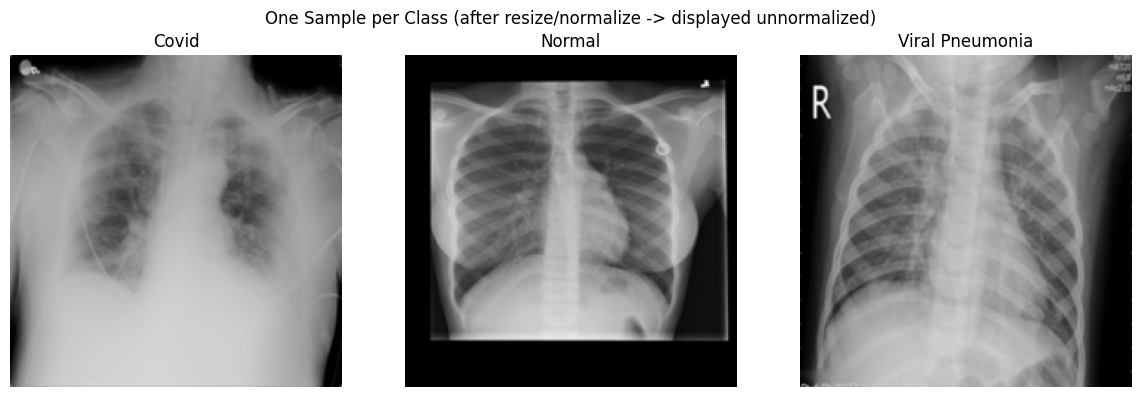

In [ ]:
# ==========================================
# 👀 Visualize one image per class (from full dataset)
# ==========================================
fig, axs = plt.subplots(1, num_classes, figsize=(4*num_classes, 4))
shown = set()
i = 0
for idx in range(len(full_ds)):
    _, label = full_ds.samples[idx]
    if label not in shown:
        img, _ = full_ds[idx]  # transformed (normalized)
        axs[i].imshow(unnormalize(img).permute(1,2,0))
        axs[i].set_title(class_names[label])
        axs[i].axis('off')
        shown.add(label)
        i += 1
        if i == num_classes:
            break
plt.suptitle("One Sample per Class (after resize/normalize -> displayed unnormalized)")
plt.tight_layout()
plt.show()


# **🧠 Simple CNN Architecture**
We define a **baseline CNN model** with:
- 3 Convolution + MaxPooling blocks
- Flatten layer
- Fully connected classifier with dropout  
This is a starting point to benchmark against more complex models later.


In [ ]:
# ==========================================
# 🧠 Simple CNN (baseline)
#
# ==========================================
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)  # last conv = index 6
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (IMAGE_SIZE//8) * (IMAGE_SIZE//8), 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN(num_classes=num_classes).to(device)
print(model)


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)


# **⚡ Loss Function & Optimizer**
We use:
- **CrossEntropyLoss** — suitable for multi-class classification  
- **Adam optimizer** — efficient for most deep learning tasks  
We also define a helper function to calculate accuracy.


In [ ]:
# ==========================================
# ⚡ Loss, Optimizer, Helpers
# ==========================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

def accuracy_from_logits(logits, labels):
    preds = torch.argmax(logits, dim=1)
    return (preds == labels).float().mean().item() * 100.0


# **🏋️ Training & Validation Loop**
We implement:
- A function `run_epoch()` to run one training or validation pass
- A function `train_model()` to run multiple epochs and track loss & accuracy for both train and validation sets  

We also track **training time** and **peak GPU memory usage**.


In [ ]:
# ==========================================
# 🏋️ Train & Validate (with timing + peak GPU memory)
# ==========================================
def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()
    total_loss, total_acc, total_n = 0.0, 0.0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        if is_train: optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        if is_train:
            loss.backward()
            optimizer.step()
        bs = labels.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_from_logits(logits, labels) * bs
        total_n    += bs
    return total_loss/total_n, total_acc/total_n

def train_model(model, train_loader, val_loader, epochs=EPOCHS):
    history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}
    if device.type == "cuda":
        torch.cuda.reset_peak_memory_stats()
    t0 = time.time()
    for ep in range(1, epochs+1):
        tr_loss, tr_acc = run_epoch(model, train_loader, optimizer)
        va_loss, va_acc = run_epoch(model, val_loader, optimizer=None)
        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(va_acc)
        print(f"Epoch {ep:02d}/{epochs} | "
              f"Train Loss {tr_loss:.4f} Acc {tr_acc:.2f}% | "
              f"Val Loss {va_loss:.4f} Acc {va_acc:.2f}%")
    total_time = time.time() - t0
    peak_mem_mb = 0.0
    if device.type == "cuda":
        peak_mem_mb = torch.cuda.max_memory_allocated(device) / (1024**2)
    print(f"\n⏳ Training Time: {total_time:.2f} sec")
    print(f"💾 Peak GPU Memory: {peak_mem_mb:.2f} MB")
    return history, total_time, peak_mem_mb


# **🚀 Model Training**
We train the CNN model for the defined number of epochs and log the performance for each epoch.


In [ ]:
# ==========================================
# 🚀 Train
# ==========================================
history, train_time_s, train_peak_mb = train_model(model, train_loader, val_loader, epochs=EPOCHS)


Epoch 01/10 | Train Loss 0.5402 Acc 79.14% | Val Loss 0.2440 Acc 92.08%
Epoch 02/10 | Train Loss 0.2428 Acc 92.17% | Val Loss 0.1866 Acc 94.88%
Epoch 03/10 | Train Loss 0.1687 Acc 94.26% | Val Loss 0.1580 Acc 94.88%
Epoch 04/10 | Train Loss 0.1407 Acc 95.32% | Val Loss 0.2013 Acc 92.08%
Epoch 05/10 | Train Loss 0.1307 Acc 95.54% | Val Loss 0.1861 Acc 94.39%
Epoch 06/10 | Train Loss 0.0861 Acc 96.99% | Val Loss 0.2336 Acc 93.56%
Epoch 07/10 | Train Loss 0.0695 Acc 97.80% | Val Loss 0.1627 Acc 95.71%
Epoch 08/10 | Train Loss 0.0664 Acc 97.45% | Val Loss 0.1758 Acc 93.56%
Epoch 09/10 | Train Loss 0.0461 Acc 98.44% | Val Loss 0.1823 Acc 95.54%
Epoch 10/10 | Train Loss 0.0236 Acc 99.29% | Val Loss 0.2073 Acc 95.21%

⏳ Training Time: 801.39 sec
💾 Peak GPU Memory: 1820.73 MB


# **🧪 Testing & Performance Evaluation**
After training, we:
- Evaluate on the **test set**
- Measure loss, accuracy, test time, and GPU memory usage


In [ ]:
# ==========================================
# 🧪 Test metrics (timing + GPU memory)
# ==========================================
if device.type == "cuda":
    torch.cuda.reset_peak_memory_stats()
t0 = time.time()
test_loss, test_acc = run_epoch(model, test_loader, optimizer=None)
test_time_s = time.time() - t0
test_peak_mb = 0.0
if device.type == "cuda":
    test_peak_mb = torch.cuda.max_memory_allocated(device) / (1024**2)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acc : {test_acc:.2f}%")
print(f"⏳ Test Time: {test_time_s:.2f} sec")
print(f"💾 Peak GPU Memory (Test): {test_peak_mb:.2f} MB")


Test Loss: 0.1451
Test Acc : 95.87%
⏳ Test Time: 108.79 sec
💾 Peak GPU Memory (Test): 1820.73 MB


# **📑 Classification Report & Confusion Matrix**
We compute:
- **Precision, Recall, F1-score** for each class
- **Confusion matrix** to visualize misclassifications


In [ ]:
# ==========================================
# 📑 Classification report & confusion matrix
# ==========================================
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        preds = torch.argmax(logits, dim=1)
        y_true.extend(labels.cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))




                 precision    recall  f1-score   support

          Covid     0.9434    0.9901    0.9662       202
         Normal     0.9545    0.9356    0.9450       202
Viral Pneumonia     0.9796    0.9505    0.9648       202

       accuracy                         0.9587       606
      macro avg     0.9592    0.9587    0.9587       606
   weighted avg     0.9592    0.9587    0.9587       606



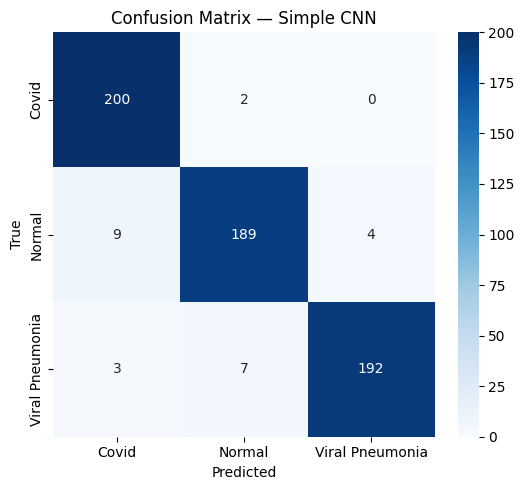

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5.5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — Simple CNN")
plt.tight_layout()
plt.show()

# **📊 Overall Model Performance**
We display a bar chart showing:
- Accuracy
- Precision
- Recall
- F1-score  
All values are in percentage format for easy interpretation.


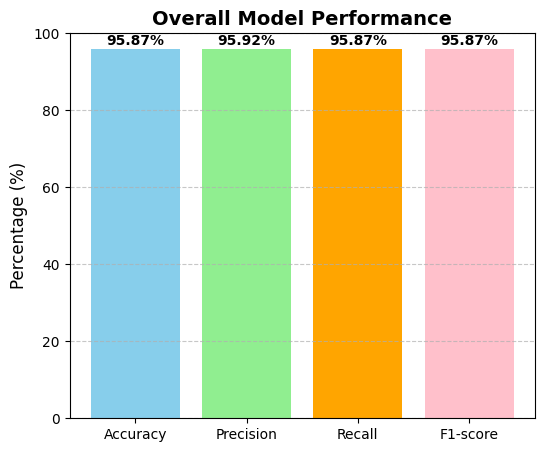

In [ ]:
import matplotlib.pyplot as plt

# Overall metrics from your results
metrics = {
    "Accuracy": 95.87,
    "Precision": 95.92,
    "Recall": 95.87,
    "F1-score": 95.87
}

# Create bar plot
plt.figure(figsize=(6, 5))
bars = plt.bar(metrics.keys(), metrics.values(), color=['skyblue', 'lightgreen', 'orange', 'pink'])

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.2, f"{height:.2f}%",
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Styling
plt.ylim(0, 100)
plt.ylabel("Percentage (%)", fontsize=12)
plt.title("Overall Model Performance", fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


# **🖼️ Test Predictions — Truth vs Predicted**
We randomly display several test images along with:
- True label (T)
- Predicted label (P)  
If the prediction is correct, the title is green; if wrong, it's red.


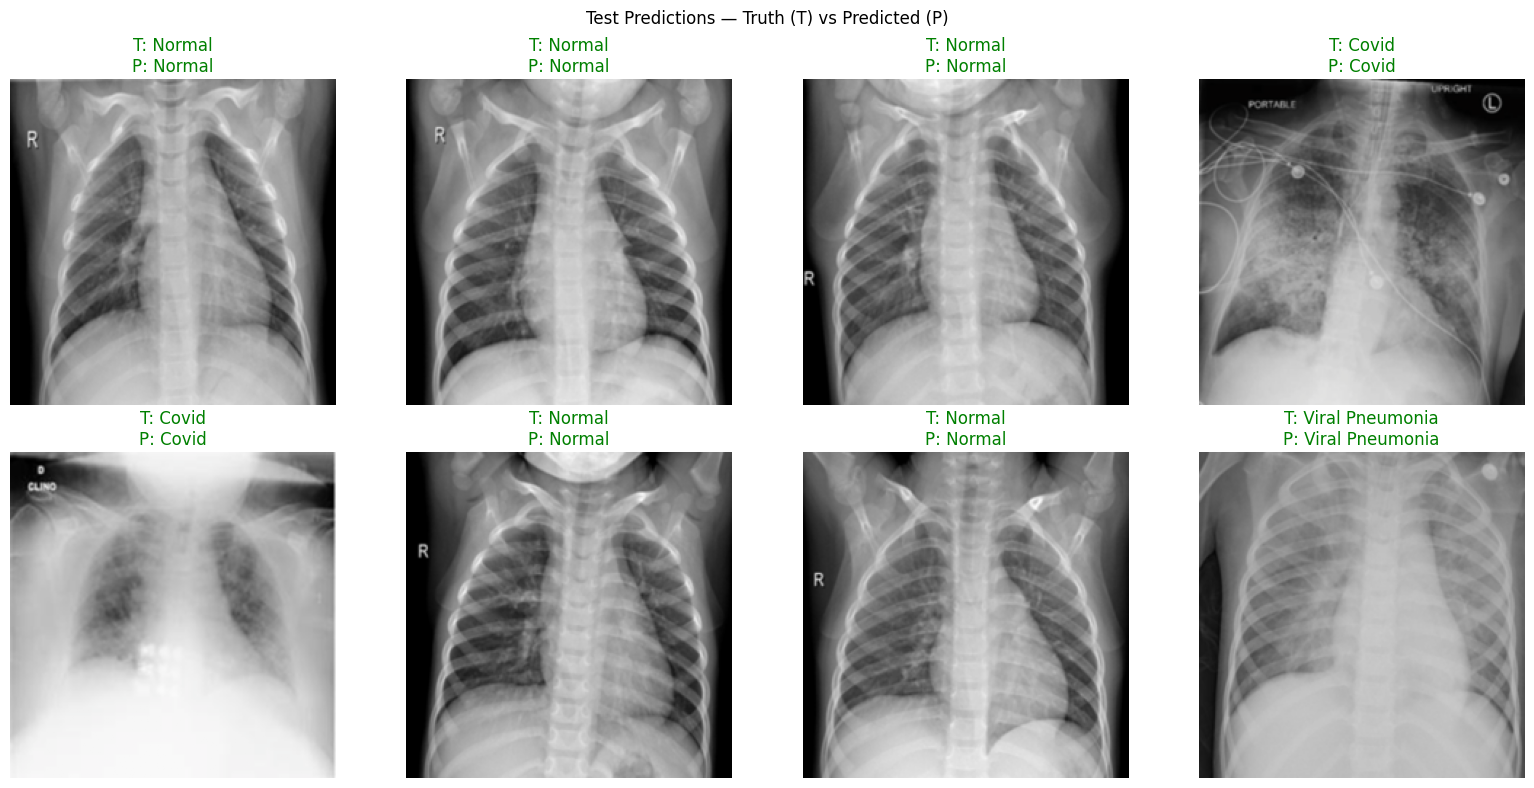

In [ ]:
# ==========================================
# 🖼️ Visual predictions on test images (truth vs predicted)
# ==========================================
model.eval()
images_shown = 8
imgs_list, labels_list, preds_list = [], [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        logits = model(imgs.to(device))
        preds = torch.argmax(logits, dim=1).cpu()
        imgs_list.append(imgs)
        labels_list.append(labels)
        preds_list.append(preds)
        if sum(x.size(0) for x in imgs_list) >= images_shown:
            break

imgs_cat = torch.cat(imgs_list)[:images_shown]
labels_cat = torch.cat(labels_list)[:images_shown]
preds_cat  = torch.cat(preds_list)[:images_shown]

cols = 4
rows = math.ceil(images_shown / cols)
plt.figure(figsize=(4*cols, 4*rows))
for i in range(images_shown):
    plt.subplot(rows, cols, i+1)
    plt.imshow(unnormalize(imgs_cat[i]).permute(1,2,0))
    t = class_names[labels_cat[i].item()]
    p = class_names[preds_cat[i].item()]
    color = "green" if t == p else "red"
    plt.title(f"T: {t}\nP: {p}", color=color)
    plt.axis('off')
plt.suptitle("Test Predictions — Truth (T) vs Predicted (P)")
plt.tight_layout()
plt.show()


# **📈 Confidence Distribution**
We visualize the model's **confidence scores** for:
- Correct predictions
- Incorrect predictions  
This helps understand whether the model is overconfident in wrong predictions.


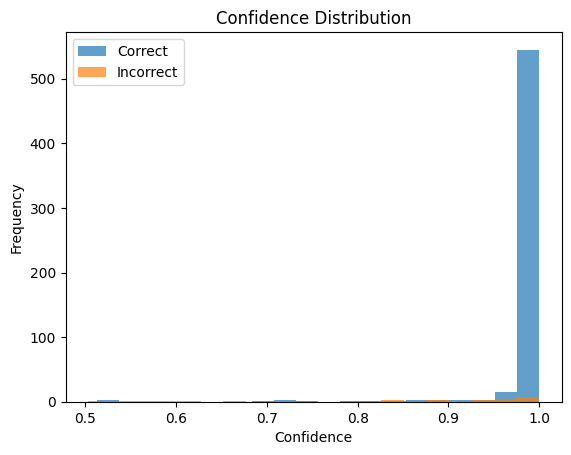

In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

model.eval()
all_probs, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        probs = F.softmax(model(imgs), dim=1)
        all_probs.extend(probs.max(1).values.cpu().numpy())
        all_labels.extend((probs.argmax(1) == labels).cpu().numpy())

plt.hist([p for p, c in zip(all_probs, all_labels) if c], bins=20, alpha=0.7, label='Correct')
plt.hist([p for p, c in zip(all_probs, all_labels) if not c], bins=20, alpha=0.7, label='Incorrect')
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.title("Confidence Distribution")
plt.legend()
plt.show()


# **🌐 t-SNE Visualization of CNN Features**
We extract features from the CNN's penultimate layer and use **t-SNE** to reduce them to 2D space for visualization.  
Points are colored by their true class labels, showing how well the features separate different classes.


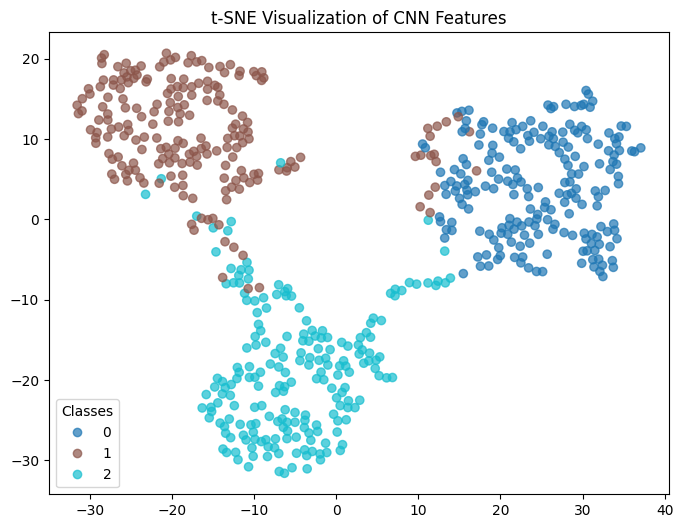

In [ ]:
# 📌 t-SNE Visualization of CNN Features
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Extract features and labels from the test set
model.eval()
features = []
labels_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Get features from penultimate layer
        feats = model(images)
        features.append(feats.cpu())
        labels_list.append(labels.cpu())

# Stack all features and labels
features = torch.cat(features)
labels_list = torch.cat(labels_list)

# Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

# Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(features_2d[:,0], features_2d[:,1], c=labels_list, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("t-SNE Visualization of CNN Features")
plt.show()


# **🚫 Misclassified Samples**
We display a grid of images that the model misclassified, with:
- True label
- Predicted label (in red)  
This helps identify common failure patterns in the model.


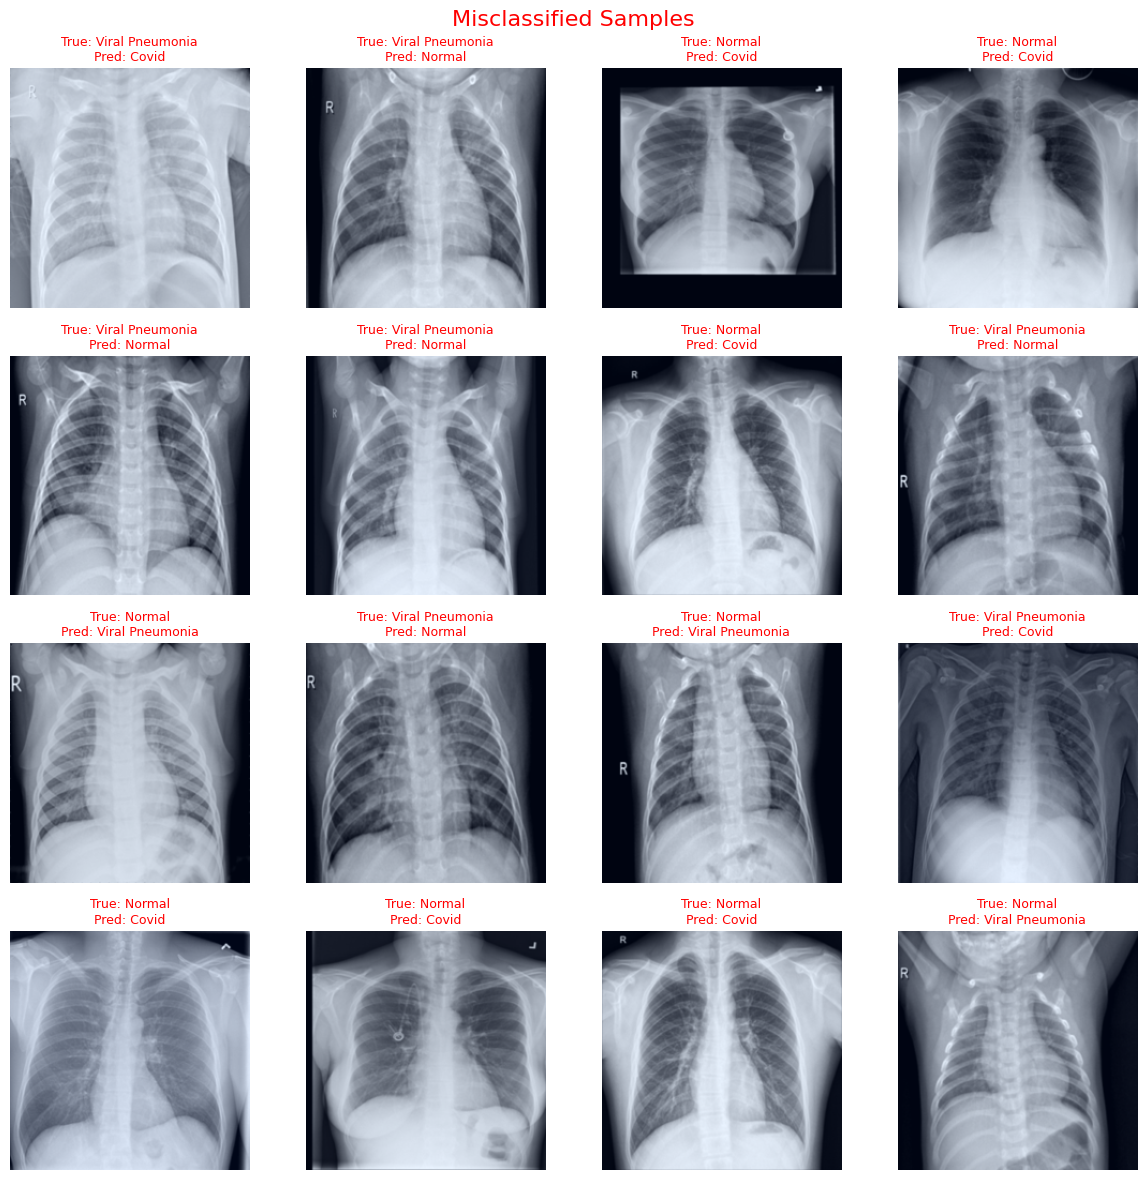

In [ ]:
import matplotlib.pyplot as plt

model.eval()
misclassified_images = []
true_labels = []
pred_labels = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for i in range(len(preds)):
            if preds[i] != targets[i]:
                misclassified_images.append(inputs[i].cpu())
                true_labels.append(targets[i].item())
                pred_labels.append(preds[i].item())

# Display first 16 misclassified samples
plt.figure(figsize=(12, 12))
for idx in range(min(16, len(misclassified_images))):
    img = misclassified_images[idx].permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())  # normalize for display

    plt.subplot(4, 4, idx+1)
    plt.imshow(img)
    plt.title(f"True: {class_names[true_labels[idx]]}\nPred: {class_names[pred_labels[idx]]}",
              fontsize=9, color='red')
    plt.axis('off')

plt.suptitle("Misclassified Samples", fontsize=16, color='red')
plt.tight_layout()
plt.show()
